In [1]:
# !pip install numpy matplotlib seaborn scikit-learn scipy tensorflow tqdm

# Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import tensorflow as tf
import os
from collections import Counter
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Loading Embedding files

In [4]:
root = os.path.abspath(os.path.join(os.getcwd(), "..",))
data_folder = os.path.join(root, "data")

train_dataset = os.path.join(data_folder, "train")
val_dataset = os.path.join(data_folder, "val")
test_dataset = os.path.join(data_folder, "test")

print(train_dataset)
print(val_dataset)
print(test_dataset)

d:\Code\NCKH2025\CNN\data\train
d:\Code\NCKH2025\CNN\data\val
d:\Code\NCKH2025\CNN\data\test


In [5]:
class_names = [d for d in os.listdir(train_dataset) if os.path.isdir(os.path.join(train_dataset, d))]
num_classes = len(class_names)
embeddings = []
images = []

In [6]:
total_files = sum(len([f for f in os.listdir(os.path.join(train_dataset, c)) if f.endswith('.npy')]) for c in class_names)

with tqdm(total=total_files, desc="Loading embeddings", unit="file") as pbar:
    for class_name in class_names:
        class_path = os.path.join(train_dataset, class_name)
        npy_files = [f for f in os.listdir(class_path) if f.endswith('.npy')]

        for file in npy_files:
            file_path = os.path.join(class_path, file)
            embeddings.append(np.load(file_path))
            images.append(file_path.replace('.npy', '.jpg'))
            pbar.update(1)

Loading embeddings: 100%|██████████| 8010/8010 [00:02<00:00, 2941.68file/s]


# Process Embeddings

In [7]:
embeddings = np.array(embeddings)
print(f"Shape embeddings: {embeddings.shape}")

Shape embeddings: (8010, 49, 1280)


In [8]:
# Reshape embeddings
num_samples, time_steps, feature_dim = embeddings.shape
X = embeddings.reshape(num_samples, time_steps * feature_dim)  # (8010, 62720)
print(f"Shape X: {X.shape}")

Shape X: (8010, 62720)


In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"Shape X_pca: {X_pca.shape}")

Shape X_pca: (8010, 2)


# Run K-Means

In [10]:
# Chạy K-Means trên dữ liệu đã giảm chiều
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
kmeans.fit(X_pca)

# Lấy nhãn cụm và centroid
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot

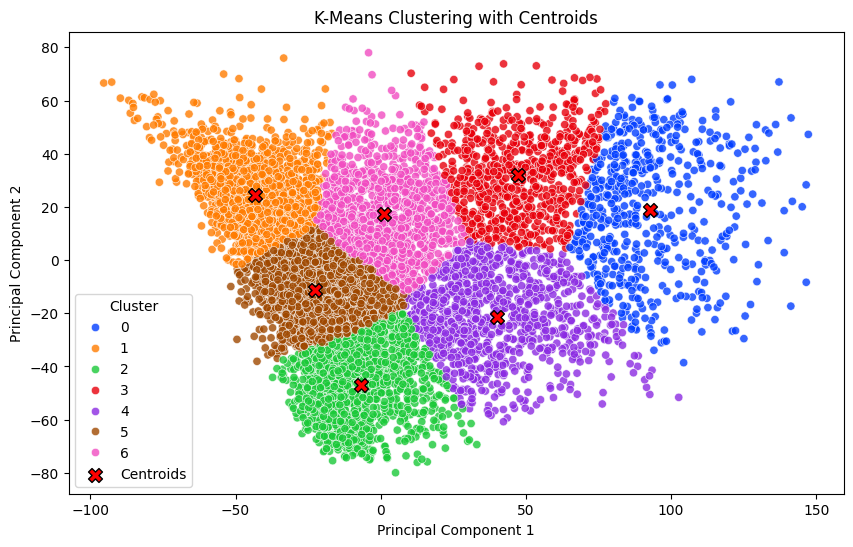

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette="bright", alpha=0.8)

plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=100, c="red", edgecolors="black", label="Centroids")

plt.title("K-Means Clustering with Centroids")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


# Data Distributtion

In [12]:
# Đếm số lượng mẫu trong mỗi cụm
cluster_counts = Counter(cluster_labels)

# Hiển thị số lượng mẫu theo từng cụm
print("Phân bố dữ liệu theo cụm:")
for cluster, count in sorted(cluster_counts.items()):
    print(f"Cụm {cluster}: {count} mẫu")


Phân bố dữ liệu theo cụm:
Cụm 0: 538 mẫu
Cụm 1: 1802 mẫu
Cụm 2: 1245 mẫu
Cụm 3: 716 mẫu
Cụm 4: 962 mẫu
Cụm 5: 1629 mẫu
Cụm 6: 1118 mẫu


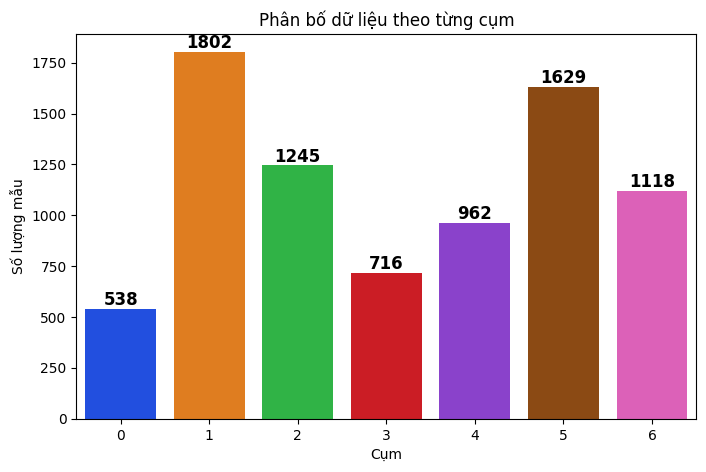

In [13]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(cluster_counts.keys()), 
                 y=list(cluster_counts.values()), 
                 hue=list(cluster_counts.keys()),
                 palette="bright", 
                 legend=False)  

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=12, fontweight="bold", color="black")
    
plt.xlabel("Cụm")
plt.ylabel("Số lượng mẫu")
plt.title("Phân bố dữ liệu theo từng cụm")
plt.show()


# Evaluate

In [14]:
# Tính khoảng cách từ mỗi điểm đến centroid tương ứng
distances = np.min(cdist(X_pca, centroids, "euclidean"), axis=1)

# Trung bình khoảng cách tới tâm cụm
avg_distance = np.mean(distances)

print(f"Khoảng cách trung bình tới tâm cụm: {avg_distance:.4f}")

Khoảng cách trung bình tới tâm cụm: 17.4436


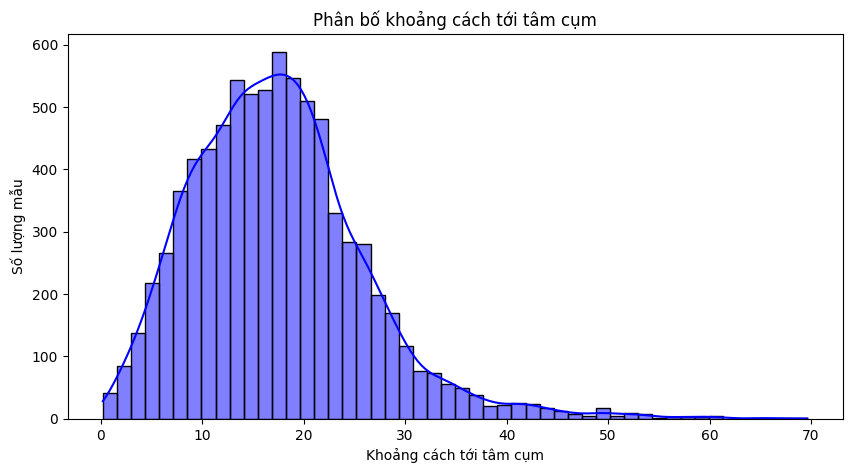

In [15]:
# Vẽ histogram phân bố khoảng cách
plt.figure(figsize=(10, 5))
sns.histplot(distances, bins=50, kde=True, color="blue")
plt.xlabel("Khoảng cách tới tâm cụm")
plt.ylabel("Số lượng mẫu")
plt.title("Phân bố khoảng cách tới tâm cụm")
plt.show()

In [16]:
from tensorflow.keras.applications import EfficientNetB1

In [17]:
pretrained_model = EfficientNetB1(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [18]:
def compute_saliency_map(img_path):
    """Tính Saliency Map cho một ảnh."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Chuyển sang TensorFlow tensor để tránh lỗi
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = pretrained_model(img_tensor)
        class_idx = tf.argmax(preds[0])  # Chọn class có xác suất cao nhất
        loss = preds[:, class_idx]

    gradients = tape.gradient(loss, img_tensor)[0]
    saliency_map = np.max(np.abs(gradients), axis=-1)

    # Chuẩn hóa về khoảng [0, 1]
    saliency_map -= saliency_map.min()
    saliency_map /= saliency_map.max()
    return saliency_map, img

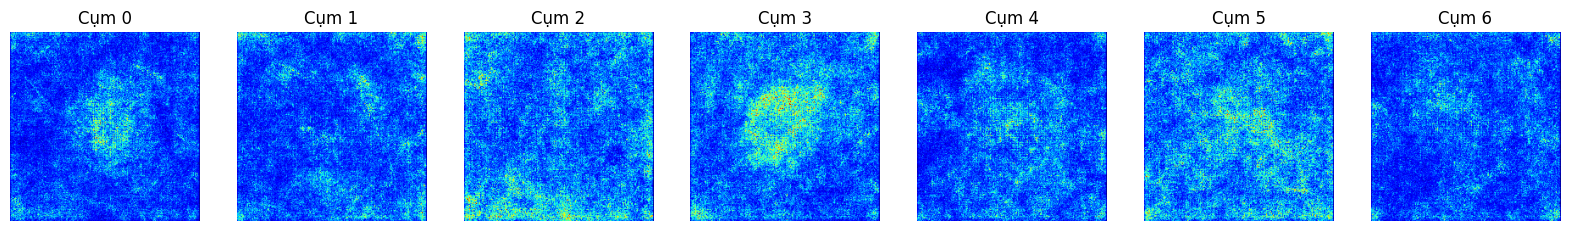

In [19]:
num_clusters = num_classes

# Tạo figure để hiển thị Saliency Map trung bình của từng cụm
fig, axes = plt.subplots(1, num_clusters, figsize=(20, 5))

# Duyệt qua từng cụm
for cluster_id in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    if len(cluster_indices) == 0:
        continue  # Nếu cụm không có ảnh, bỏ qua

    saliency_maps = []

    # Lấy tối đa 10 ảnh trong mỗi cụm để tính trung bình
    for idx in cluster_indices[:10]:
        saliency_map, _ = compute_saliency_map(images[idx])
        saliency_maps.append(saliency_map)

    # Tính trung bình Saliency Map của cụm
    mean_saliency_map = np.mean(np.array(saliency_maps), axis=0)

    # Hiển thị Saliency Map trung bình
    ax = axes[cluster_id]
    ax.imshow(mean_saliency_map, cmap="jet")
    ax.set_title(f"Cụm {cluster_id}")
    ax.axis("off")
plt.show()
